In [1]:
import torchvision
import torch
import tqdm
import numpy as np
from torchvision.datasets import MNIST
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from lets_plot import *

import sklearn
import sklearn.metrics

import matplotlib.pyplot as plt
LetsPlot.setup_html()

In [2]:
import importlib

import mnist
import adversarial

importlib.reload(mnist)
importlib.reload(adversarial)

from mnist import *
from adversarial import *


## Load the dataset

In [3]:

mnist_train = load_data(train=True)
mnist_test = load_data(train=False)

train_dataset = MnistDataset(mnist_train)


In [4]:
train_X = torch.stack([t[0] for t in mnist_train])
train_y = torch.stack([t[1] for t in mnist_train])

In [5]:
test_X = torch.stack([t[0] for t in mnist_test])
test_y = torch.stack([t[1] for t in mnist_test])

## Train the model

In [6]:
model = MnistClassifier()


In [7]:
loss_fct = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

epochs = 1

train_loader = DataLoader(train_dataset, batch_size=64)

for e in (range(epochs)):
    model.train()
    losses = []
    
    pbar = tqdm.tqdm(train_loader)
    for batch in pbar:
        optimizer.zero_grad()
        out = model(batch['data'])
        loss = loss_fct(out, batch['label'])
        loss.backward()
        
        losses.append(loss.item())
        pbar.set_description(f'Loss: {loss.item():.04f}')
        
        optimizer.step()
        

Loss: 1.4641: 100%|██████████| 938/938 [00:22<00:00, 41.81it/s]


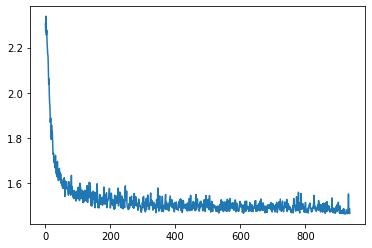

In [8]:
# ggplot({'X': list(range(len(losses))), 'Y': losses}) + geom_line(aes(x='X', y='Y'))
plt.plot(losses)

In [9]:
model.eval()
train_pred = model(train_X)
print(sklearn.metrics.classification_report(train_pred.argmax(dim=1).detach().numpy(), train_y))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5984
           1       0.99      0.96      0.98      6968
           2       0.96      0.97      0.97      5889
           3       0.97      0.98      0.98      6090
           4       0.98      0.97      0.98      5916
           5       0.97      0.99      0.98      5362
           6       0.99      0.99      0.99      5920
           7       0.98      0.96      0.97      6386
           8       0.95      0.98      0.96      5639
           9       0.96      0.97      0.96      5846

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



In [10]:
model.eval()
test_pred = model(test_X)
print(sklearn.metrics.classification_report(test_pred.argmax(dim=1).detach().numpy(), test_y))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1001
           1       1.00      0.97      0.98      1168
           2       0.96      0.98      0.97      1018
           3       0.98      0.97      0.98      1016
           4       0.98      0.98      0.98       987
           5       0.98      0.98      0.98       885
           6       0.98      0.99      0.99       944
           7       0.97      0.97      0.97      1031
           8       0.96      0.98      0.97       953
           9       0.96      0.97      0.97       997

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Sample and train adversarial examples

In [11]:
adv_examples_count = 100
adv_X, adv_y = train_X[:adv_examples_count], train_y[:adv_examples_count]
adv_examples = train_adv_bim(model, CrossEntropyLoss(), adv_X.clone(), adv_y.clone())


In [12]:
model.eval()
adv_pred = model(adv_examples).argmax(dim=1).detach()
adv_pred, adv_y

(tensor([3, 6, 4, 4, 1, 8, 4, 2, 1, 1, 2, 6, 3, 5, 1, 9, 7, 1, 9, 7, 4, 6, 4, 4,
         4, 3, 9, 3, 7, 8, 1, 1, 5, 1, 0, 3, 1, 6, 2, 0, 9, 1, 9, 4, 7, 4, 2, 3,
         3, 5, 3, 5, 9, 7, 4, 9, 0, 4, 4, 4, 9, 7, 9, 9, 0, 3, 6, 9, 5, 8, 2, 9,
         1, 1, 3, 8, 1, 4, 4, 1, 8, 0, 7, 2, 7, 4, 7, 7, 0, 7, 6, 7, 4, 8, 3, 0,
         9, 1, 3, 7]),
 tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
         1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
         9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
         1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
         7, 8, 3, 1]))

## Evaluate model on the real and adversarial datasets

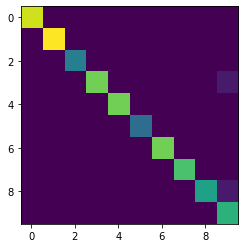

In [13]:
real_pred = model(adv_X).argmax(dim=1).detach().numpy()
conf = sklearn.metrics.confusion_matrix(real_pred, adv_y).astype(np.float)
# ggplot() + geom_image(conf)
plt.imshow(conf)

              precision    recall  f1-score   support

           0       0.38      0.71      0.50         7
           1       0.21      0.20      0.21        15
           2       0.00      0.00      0.00         6
           3       0.45      0.42      0.43        12
           4       0.36      0.24      0.29        17
           5       0.00      0.00      0.00         5
           6       0.18      0.33      0.24         6
           7       0.20      0.15      0.17        13
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        13

    accuracy                           0.21       100
   macro avg       0.18      0.21      0.18       100
weighted avg       0.21      0.21      0.20       100



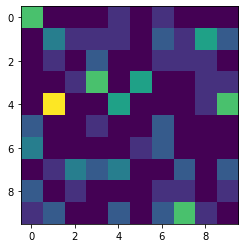

In [14]:
print(sklearn.metrics.classification_report(adv_pred.numpy(), adv_y))
conf = sklearn.metrics.confusion_matrix(adv_pred.numpy(), adv_y).astype(np.float)
# ggplot() + geom_image(conf)
plt.imshow(conf)

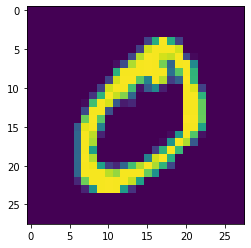

In [15]:
# ggplot() + geom_image(adv_X[1].numpy().reshape(28, 28))
plt.imshow(adv_X[1].numpy().reshape(28, 28))

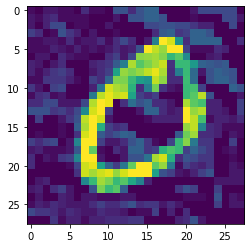

In [16]:
# ggplot() + geom_image(adv_examples[1].numpy().reshape(28, 28))
plt.imshow(adv_examples[1].numpy().reshape(28, 28))